In [1]:
import pylab as plt
import numpy as np
import torch 
from torch.autograd import Variable

%matplotlib inline

# データの準備

In [2]:
u1 = np.r_[np.zeros(40), np.ones(30), np.ones(50)*2, np.ones(30), np.zeros(20), np.ones(30) ]
u2 = np.r_[np.ones(25), np.zeros(25), np.ones(25)*2, np.ones(55), np.zeros(35), np.ones(35) ]
u = np.c_[u1, u2]

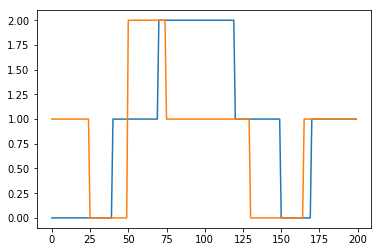

In [3]:
plt.plot(u)

In [4]:
sx = np.random.random(len(u)) * 6
sy = np.random.random(len(u)) * 6
sd = np.random.random(len(u)) * 6

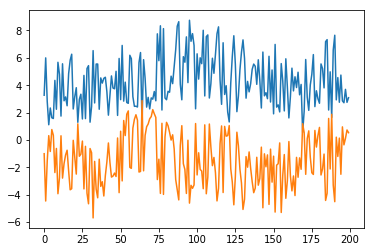

In [5]:
x = np.c_[
    u1 + sx + np.random.random(len(u)),
    u2 - sx + np.random.random(len(u)),   
]
plt.plot(x)

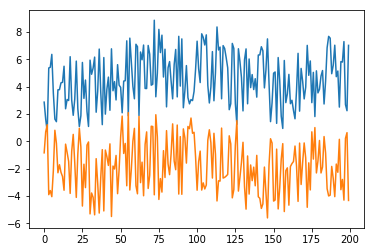

In [6]:
y = np.c_[
    u1 + sy + np.random.random(len(u)),
    u2 - sy + np.random.random(len(u)),   
]
plt.plot(y)

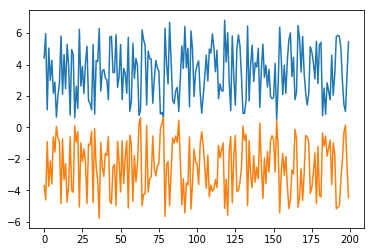

In [7]:
dummy = np.c_[
    sd + np.random.random(len(u)),
    -sd + np.random.random(len(u)),   
]
plt.plot(dummy)

# Scikit-Learnによる実装

In [8]:
from sklearn.cross_decomposition import CCA

In [9]:
cca = CCA(n_components=1)

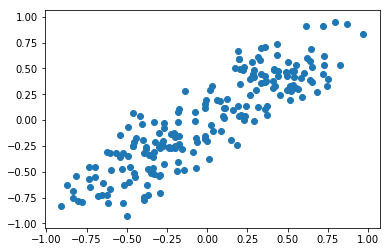

In [10]:
t_x, t_y = cca.fit_transform(x,y)
plt.scatter(t_x, t_y)

In [11]:
cca.x_weights_

array([[ 0.70199831],
       [ 0.71217861]])

In [12]:
cca.y_weights_

array([[ 0.70790696],
       [ 0.70630569]])

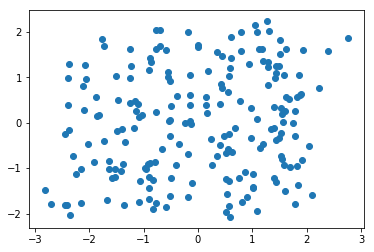

In [13]:
t_x, t_d = cca.fit_transform(x,dummy)
plt.scatter(t_x, t_d)

# PyTorchによる実装

In [14]:
x -= np.mean(x, axis=0)
y -= np.mean(y, axis=0)
dummy -= np.mean(dummy, axis=0)
N = len(x)

vxx = np.dot(x.transpose(), x)/N
vyy = np.dot(y.transpose(), y)/N
vxy = np.dot(x.transpose(), y)/N

In [15]:
X = Variable(torch.from_numpy(x)).float()
Y = Variable(torch.from_numpy(y)).float()
Dummy = Variable(torch.from_numpy(dummy)).float()

In [16]:
a = Variable(torch.randn(2,1), requires_grad=True)
b = Variable(torch.randn(2,1), requires_grad=True)

In [17]:
Vxx = Variable(torch.from_numpy(vxx)).float()
Vyy = Variable(torch.from_numpy(vyy)).float()
Vxy = Variable(torch.from_numpy(vxy)).float()

In [19]:
nb_steps = 1000
lr = 0.001
hist = []
for i in range(nb_steps):
    Loss = torch.mm(torch.mm(torch.t(a), Vxy), b)  \
         + (1 - torch.mm(torch.mm(torch.t(a),Vxx),a)) **2  \
         + (1 - torch.mm(torch.mm(torch.t(b),Vyy),b)) **2
    hist.append(Loss.data.numpy()[0,0])
    Loss.backward()
    a.data -= a.grad.data * lr
    a.grad.data.zero_()
    b.data -= b.grad.data * lr
    b.grad.data.zero_()

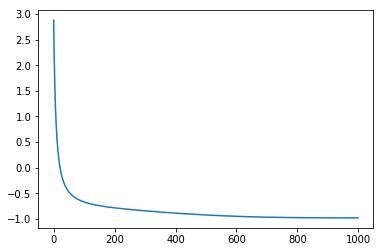

In [20]:
plt.plot(hist)

In [21]:
a_n = a.data.numpy()
b_n = b.data.numpy()

In [22]:
print(a_n)
print(b_n)

[[-0.92819017]
 [-0.90693611]]
[[ 0.92218524]
 [ 0.93290883]]


In [23]:
x_t = np.dot(a_n.transpose(), x.transpose())
y_t = np.dot(b_n.transpose(), y.transpose())

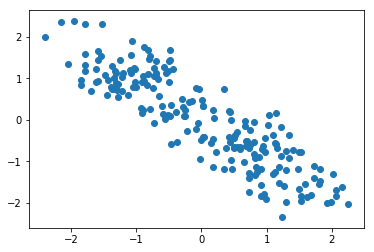

In [24]:
plt.scatter(x_t, y_t)